In [1]:
import numpy as np
import xarray as xr
import capytaine as cpt
import matplotlib.pyplot as plt
from hinge_barge import HingeBarge

# BenchWEC's hinge-barge simulation

The present document presents some numerical results of a three-body hinge-barge using linear potential flow theory, as solved with the BEM solver Capytaine.

In [2]:
# Which version of Capytaine has been used
cpt.__version__

'1.2dev'

## Defining the geometry of the hinge-barge

We initialize the geometry of the hinge-barge by assembling three rectangular parallelepiped.

TODO: add the damping plate.

In [3]:
bd1 = cpt.RectangularParallelepiped(size=(0.68, 0.4, 0.1), resolution=(10, 8, 2))
bd2 = cpt.RectangularParallelepiped(size=(0.68, 0.4, 0.1), resolution=(10, 8, 2))
bd3 = cpt.RectangularParallelepiped(size=(1.0, 0.4, 0.1), resolution=(20, 8, 2))

In [4]:
hb = HingeBarge(components=[bd1, bd2, bd3], distance_between_bodies=0.06, name="BenchWEC_barge")
hb.compute_hydrostatics(rho_water=1025.0, g=9.81)
hb.keep_immersed_part()

HingeBarge(mesh=body_0+body_1+body_2_mesh, dofs={Surge, Sway, Heave, Roll, Pitch, Yaw, Hinge_0, Hinge_1}, name=BenchWEC_barge)

### Example of arbitrary motions of the barge

The barge has 8 degrees of freedom.
As a validation test, we can display some of the degrees of freedom of the barge.

#### Pitch

In [5]:
example_motion = {"Pitch": 0.1}  # The dof and its amplitude
hb.animate(example_motion, loop_duration=2.0).embed_in_notebook(camera_position=(-3, -3, 4))

#### First hinge

In [6]:
example_motion = {"Hinge_0": 0.1}
hb.animate(example_motion, loop_duration=2.0).embed_in_notebook(camera_position=(-3, -3, 4))

#### Second hinge

In [7]:
example_motion = {"Hinge_1": 0.1}
hb.animate(example_motion, loop_duration=2.0).embed_in_notebook(camera_position=(-3, -3, 4))

#### Some linear combination of the dofs

In [8]:
example_motion = {"Heave": 0.1j, "Hinge_0": 0.1, "Hinge_1": -0.1, "Yaw": 0.05}
hb.animate(example_motion, loop_duration=2.0).embed_in_notebook(camera_position=(-3, -3, 4))

## Computation of the hydrodynamics

We solve linear potential flow problems for a range of frequencies in order to compute the hydrodynamic properties of the body.

In [9]:
solver = cpt.BEMSolver()

The result is organised in a dataset containing the ranges of input variables and the resulting matrices.

In [10]:
test_matrix = xr.Dataset(coords={
        'omega': np.linspace(1.0, 10.0, 50),
        'wave_direction': [0.0, np.pi/2],
        'radiating_dof': list(hb.dofs),
        'rho': 1025.0,
})
dataset = solver.fill_dataset(test_matrix, [hb])
dataset

<xarray.Dataset>
Dimensions:                (influenced_dof: 8, omega: 50, radiating_dof: 8, wave_direction: 2)
Coordinates:
    water_depth            float64 inf
    rho                    float64 1.025e+03
  * omega                  (omega) float64 1.0 1.184 1.367 ... 9.633 9.816 10.0
  * influenced_dof         (influenced_dof) object 'Surge' 'Sway' ... 'Hinge_1'
    g                      float64 9.81
    body_name              <U14 'BenchWEC_barge'
  * radiating_dof          (radiating_dof) object 'Surge' 'Sway' ... 'Hinge_1'
  * wave_direction         (wave_direction) float64 0.0 1.571
Data variables:
    added_mass             (omega, radiating_dof, influenced_dof) float64 4.704 ... 64.48
    radiation_damping      (omega, radiating_dof, influenced_dof) float64 0.000797 ... 260.4
    diffraction_force      (omega, wave_direction, influenced_dof) complex128 (0.04035750625811926-4.1797639833041105j) ... (-2121.966697143349-1833.8321558222701j)
    Froude_Krylov_force    (omega, wave_direction, influenced_dof) complex128 (0.039989908584743716-48.12401022524821j) ... (1642.7151454858006-1.3952727861976655e-13j)
    mass                   (influenced_dof, radiating_dof) float64 48.38 ... 27.67
    hydrostatic_stiffness  (influenced_dof, radiating_dof) float64 0.0 ... 4.886e+03
Attributes:
    start_of_computation:                     2020-04-20T17:46:41.819087
    green_function:                           Delhommeau
    tabulation_nb_integration_points:         251
    finite_depth_prony_decomposition_method:  fortran
    engine:                                   BasicMatrixEngine
    matrix_cache_size:                        1
    linear_solver:                            gmres
    creation_of_dataset:                      2020-04-20T17:46:59.064795
    incoming_waves_convention:                nemoh
    capytaine_version:                        1.2dev

## Computation of the motion

The RAO is computed as the solution of the equation of motion in frequency domain
$$
\left(- \omega^2 (M + A(\omega)) + i \omega (R(\omega) + K_{\text{pto}}) + S \right) X = F(\omega)
$$
where 
* $M$ is the mass matrix,
* $A$ is the added mass matrix,
* $R$ is the radiation damping matrix,
* $K_{\text{pto}}$ is the dissipation matrix due to the PTO,
* $S$ is the hydrostatic stiffness
* $F(\omega)$ is the excitation force.

#### Hydrostatic

The mass matrix and hydrostatic stiffness have been computed above. They are accessible in the dataset. For instance:

In [11]:
dataset['mass'].values

array([[ 48.38      ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  48.38      ,   0.        ,   0.        ,
          0.        ,   0.3936    ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  48.38      ,   0.        ,
         -0.3936    ,   0.        ,  36.3506    ,  31.4962    ],
       [  0.        ,   0.        ,   0.        ,   0.68538333,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  -0.3936    ,   0.        ,
         25.69702333,   0.        , -15.52404867,   6.083334  ],
       [  0.        ,   0.3936    ,   0.        ,   0.        ,
          0.        ,  26.30177333,   0.        ,   0.        ],
       [  0.        ,   0.        ,  36.3506    ,   0.        ,
        -15.52404867,   0.        ,  39.70418133,  23.15751067],
       [  0.        ,   0.        ,  31.4962    ,   0.        ,
          6.083334  ,   0.       

#### PTO
Let us now define the PTO matrix by assigning a dissipation coefficient to both hinges:

In [12]:
pto = {"Hinge_0": 10, "Hinge_1": 16}
Kpto = hb.pto_dissipation_matrix(pto)
Kpto.values

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 16.]])

#### RAO for waves in the direction of the barge

The following function computes the RAO for a given wave direction and all wave frequencies.
Only PTO dissipation has been included for the moment.

The response motion is a linear combination of dofs for each of frequencies, that is a (nb_frequencies × nb_dof) matrix.

In [24]:
rao = cpt.post_pro.rao(dataset, wave_direction=0.0, dissipation=Kpto)
rao

<xarray.DataArray (omega: 50, radiating_dof: 8)>
array([[ 1.26237843e-02+9.99264796e-01j, -1.85648690e-07+3.79057966e-10j,
         1.20521433e+00-6.54309315e-03j,  1.42490561e-07-1.08909768e-07j,
        -8.98486420e-01-2.42314669e-01j, -3.08926640e-07+9.34722831e-09j,
        -1.06080911e+00-1.38114038e-01j,  8.93541375e-01+1.53378392e-01j],
       [ 1.57466285e-02+9.95259365e-01j, -1.86381978e-07-2.15444110e-10j,
         1.25160392e+00-4.68658591e-02j,  2.11748943e-07-1.61353096e-07j,
        -1.08186950e+00-1.94362386e-01j, -3.12385058e-07+1.35675366e-08j,
        -1.28023465e+00-2.24597375e-02j,  1.06902967e+00+6.98484698e-02j],
       [ 1.84631283e-02+9.89466983e-01j, -1.86028070e-07+1.34747446e-09j,
         1.29645798e+00-9.66911638e-02j,  3.00702638e-07-2.27993090e-07j,
        -1.24035343e+00-1.42232352e-01j, -3.14269022e-07+2.11299529e-08j,
        -1.47299035e+00+1.08150568e-01j,  1.21377499e+00-2.30468282e-02j],
       [ 2.14134632e-02+9.81505066e-01j, -1.83562395e-07+5.28277313e-09j,
         1.34197319e+00-1.55585664e-01j,  4.19685730e-07-3.09381425e-07j,
        -1.37636812e+00-9.50325821e-02j, -3.13626925e-07+3.28799049e-08j,
        -1.64304389e+00+2.43117648e-01j,  1.32789113e+00-1.15279429e-01j],
       [ 2.45628159e-02+9.71015026e-01j, -1.74962937e-07+1.37288270e-08j,
         1.39068531e+00-2.23786329e-01j,  5.82442482e-07-3.99412818e-07j,
        -1.49330001e+00-5.99725019e-02j, -3.04990242e-07+5.13558008e-08j,
        -1.79562722e+00+3.74238766e-01j,  1.41212229e+00-1.98162853e-01j],
       [ 2.88226469e-02+9.57211089e-01j, -1.54942444e-07+2.65156519e-08j,
         1.44548059e+00-3.02888023e-01j,  8.49431676e-07-4.89790965e-07j,
        -1.59484061e+00-3.91720052e-02j, -2.83176153e-07+7.65813418e-08j,
        -1.93630232e+00+4.99391989e-01j,  1.46677582e+00-2.67370336e-01j],
       [ 3.42060677e-02+9.39763640e-01j, -1.11016031e-07+4.01331706e-08j,
         1.50916018e+00-3.94931678e-01j,  1.36265949e-06-5.69305527e-07j,
        -1.68488249e+00-3.46270327e-02j, -2.34388239e-07+1.03199987e-07j,
        -2.07069405e+00+6.16968013e-01j,  1.49207339e+00-3.17681050e-01j],
       [ 4.26185162e-02+9.17807081e-01j, -2.23032638e-08+4.00657243e-08j,
         1.58508559e+00-5.02956896e-01j,  2.64908622e-06-6.80752951e-07j,
        -1.76861450e+00-4.62922914e-02j, -1.47919417e-07+1.11336102e-07j,
        -2.20565476e+00+7.28080320e-01j,  1.48869151e+00-3.44645005e-01j],
       [ 5.46137447e-02+8.90776102e-01j,  1.82083696e-07-1.60830620e-08j,
         1.67579351e+00-6.31907430e-01j,  7.45857227e-06-1.44377338e-06j,
        -1.84811010e+00-6.87774007e-02j, -2.50553034e-08+6.37193086e-08j,
        -2.34347983e+00+8.40522647e-01j,  1.45337329e+00-3.47602145e-01j],
       [ 7.16853396e-02+8.57872403e-01j, -2.81805978e-06-6.16668268e-07j,
         1.78418755e+00-7.87357959e-01j, -1.04144939e-04-2.34642070e-05j,
        -1.92950940e+00-9.90977638e-02j,  3.79733363e-08-9.39794113e-08j,
        -2.49008880e+00+9.59893829e-01j,  1.38672024e+00-3.21572294e-01j],
       [ 9.51364467e-02+8.18280940e-01j, -2.52499702e-07-1.14361397e-07j,
         1.91338904e+00-9.77731212e-01j, -1.12235127e-05+3.72973404e-06j,
        -2.01826976e+00-1.31509088e-01j,  9.30696232e-08-3.48932848e-07j,
        -2.64969204e+00+1.09589568e+00j,  1.28747986e+00-2.61492776e-01j],
       [ 1.25076137e-01+7.70960592e-01j, -2.54410727e-07-2.85192557e-07j,
         2.06571932e+00-1.21557198e+00j, -6.44959469e-06+4.51857769e-06j,
        -2.12150339e+00-1.57364409e-01j, -1.22370673e-07-6.66185284e-07j,
        -2.82684217e+00+1.26282276e+00j,  1.15646769e+00-1.61101797e-01j],
       [ 1.62053906e-01+7.14857464e-01j, -5.75145793e-07-7.49194570e-07j,
         2.24053289e+00-1.52034535e+00j, -5.25266341e-06-8.24637102e-06j,
        -2.24737711e+00-1.63975121e-01j, -6.64053985e-07-8.34259130e-07j,
        -3.02507473e+00+1.48183694e+00j,  9.97795436e-01-1.16389177e-02j],
       [ 2.05070292e-01+6.48173421e-01j, -1.22772134e-06-4.53023951e-07j,
         2.43078

##### Display of a response motion

We can display the motion of the barge for the frequency $\omega = 4 s^{-1}$ (actually the nearest frequency in our dataset). As we will see below, this is the frequency at which the most power is collected.

The waves travel from the bottom left ($x = -\infty$) to the top right ($x = + \infty$).

In [25]:
wave_amplitude = 0.02
anim_omega = 4.0

motion = wave_amplitude * rao.sel(omega=anim_omega, method='nearest')
animation = hb.animate(motion, loop_duration=2*np.pi/anim_omega)
animation.embed_in_notebook(camera_position=(-3, -3, 4))

#### RAO for side waves

The waves now travel from the bottom right ($y = - \infty$) to the top left ($y = + \infty$).

In [26]:
side_rao = cpt.post_pro.rao(dataset, wave_direction=np.pi/2, dissipation=Kpto)
side_motion = wave_amplitude * side_rao.sel(omega=anim_omega, method='nearest')
animation = hb.animate(side_motion, loop_duration=2*np.pi/anim_omega)
animation.embed_in_notebook(camera_position=(-3, -3, 4))

## Power

Finally the power collected by the PTO can be computed as

$$
P(\omega) = \frac{1}{2} \sum_{jk} K_{\text{pto} j k} | i \omega X_j (\omega) |^2
$$

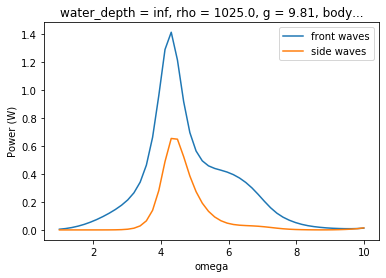

In [23]:
def power(rao):
    power_per_dof = 0.5 * hb.pto_dissipation_matrix(pto) @ (np.square(np.abs(1j * dataset.coords['omega'] * wave_amplitude * rao)))
    return power_per_dof.sum(dim="influenced_dof")

power(rao).plot(label="front waves")
power(side_rao).plot(label="side waves")
plt.ylabel("Power (W)")
plt.legend()